In [271]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import sys 
sys.path.append('..')
from utils.dataloader import load_data, create_count_data
from utils.plotting_functions import plot_histograms, plot_time_series, ts_percentile

pio.templates.default = "plotly_white"

#plt.style.use('ggplot')
pd.set_option('display.max_columns', None)


ImportError: cannot import name 'ts_percentile' from 'utils.plotting_functions' (/Users/julian/Documents/GitHub/Thesis/notebooks/../utils/plotting_functions.py)

In [2]:
df = load_data()

In [3]:
def create_hub_name(station):
   hub_name = station.rsplit('/', 1)[1].lstrip().rsplit(' ', 1)[0]
   if hub_name == 'BRYANT #':
      return 'BRYANT'
   else: 
      return hub_name

def count_plugs(station, station_list, no_plug_list):
   no_plugs = len(df['Port Number'].loc[df['Station Name'] == station].unique())
   return no_plugs
   '''if 'SHERMAN' in station:
      return 2
   else: 
      return no_plugs'''

In [4]:
## Add hub colu,n
df['Hub'] = df['Station Name'].apply(create_hub_name)

In [5]:
port_num = []
station_name = []
j = 0
for i in df['Station Name'].unique():
    station_name.append(i)
    df_port_num = df['Port Number'].loc[df['Station Name'] == i].unique()
    port_num.append(int(len(df_port_num)))

plug_per_station = dict(zip(station_name, port_num))


In [6]:
## Poulate variable no. of plugs with plugs pr. unique station
df['No. Plugs'] = np.zeros(len(df))
for key, value in plug_per_station.items():
    df.loc[df['Station Name'] == key, ['No. Plugs']] = value

<AxesSubplot:title={'center':'Total plugin events pr. hub'}, xlabel='Hub'>

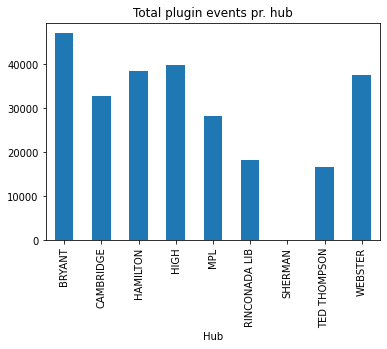

In [7]:
df.groupby('Hub')['Plug In Event Id'].count().plot.bar(title = 'Total plugin events pr. hub')

<AxesSubplot:title={'center':'Total plugs per station'}, xlabel='Station Name'>

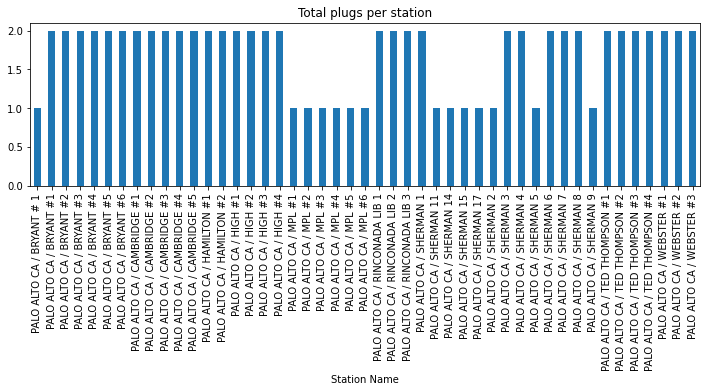

In [8]:
df.groupby('Station Name')['No. Plugs'].first().plot.bar(title = 'Total plugs per station', figsize=(12, 3))

In [9]:
## Find first time a specific plug at a specific station is in use
list_of_first_records = []
for i in df['Station Name'].unique():
    list_of_first_records.append(df[df['Station Name'] == i].iloc[0].values)
df_charging_stations = pd.DataFrame(list_of_first_records)
df_charging_stations = df_charging_stations.set_axis(df.columns.unique().values, axis=1, inplace=False)

In [10]:
## Count no. of charging stations pr. hub over time
df_charging_stations['No. Stations'] = df_charging_stations.groupby('Hub').cumcount()
df_charging_stations['No. Stations'] = df_charging_stations['No. Stations'] + 1
df_charging_stations['No. Plugs per Hub'] = df_charging_stations.groupby('Hub').cumsum()['No. Plugs']
df_charging_stations_per_hub = df_charging_stations[['Station Name', 'Start Date', 'Port Number', 'Hub', 'No. Stations', 'No. Plugs per Hub']]

In [11]:
## Create df with time and hubs as rows and columns respectively. Filled with number of charging stations
df_hub = df_charging_stations_per_hub.pivot_table(values='No. Stations', index=['Start Date'], columns='Hub', aggfunc='first')
df_hub = df_hub.fillna(0)
df_hub = df_hub.replace(to_replace=0, method='ffill')

In [12]:
df_plug_hub = df_charging_stations_per_hub.pivot_table(values='No. Plugs per Hub', index=['Start Date'], columns='Hub', aggfunc='first')
df_plug_hub = df_plug_hub.fillna(0)
df_plug_hub = df_plug_hub.replace(to_replace=0, method='ffill')

<AxesSubplot:title={'center':'No. of plugs pr. hub ($\\tau$)'}, xlabel='Start Date'>

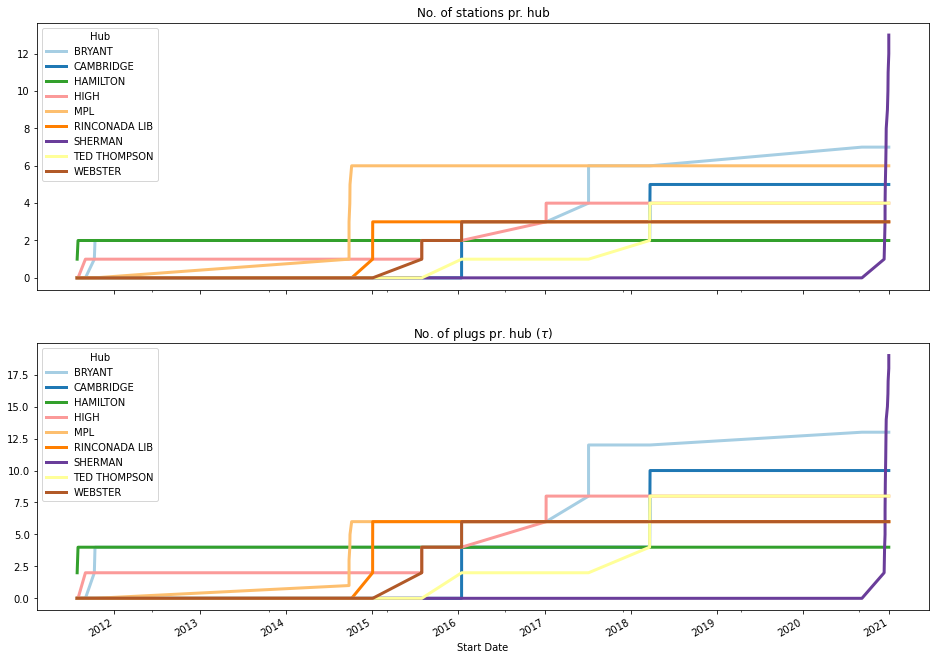

In [22]:
fig, axes = plt.subplots(2, figsize=(16,12), sharex=True)
df_hub.plot(colormap = 'Paired', linewidth = 3, title = 'No. of stations pr. hub', ax=axes[0])
df_plug_hub.plot(colormap = 'Paired', linewidth = 3, title = r'No. of plugs pr. hub ($\tau$)', ax=axes[1])

## Exploring distributions from when the models begin recording

In [47]:
## Read count data format
df_event = pd.read_csv('/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_viz.csv', index_col=0, parse_dates=['Period'])

#df_event = create_count_data(df, interval_length = 30, save = True)

In [ ]:
## Getting first record of each station 
first_date_rec = []
j = 0

for i in df_charging_stations['Hub'].unique():
    first_recording = df_charging_stations['Start Date'].loc[df_charging_stations['Hub'] == i].iloc[0]
    first_date_rec.append(first_recording)
    

station_name = df_event.columns.values
hub_start_dict = dict(zip(station_name, first_date_rec))


In [265]:
#plot_list = df_event.columns.values
def plot_histograms(df_in, plot_best_estimate = False, save_figure = False):
    from scipy.optimize import curve_fit
    from scipy.stats import poisson
    
    plot_list = df_in['Cluster'].unique()[:-1]
    
    fig, axes = plt.subplots(4,2, figsize=(12, 16))
    i = 0
    j = 0
    for key in plot_list:
        cluster_events = df_in['Sessions'].loc[df_in['Cluster'] == key]
        cluster_mean = np.mean(df_in['Sessions'].loc[df_in['Cluster'] == key])
        cluster_sd = np.std(df_in['Sessions'].loc[df_in['Cluster'] == key])

        #cluster_events = df_event[key].values
        #cluster_mean = np.mean(cluster_events)
        #cluster_sd = np.std(cluster_events)

        entries, bin_edges, patches  = axes[i,j].hist(cluster_events, bins = range(int(np.max(cluster_events))+3), 
                                                      rwidth=0.7, density = True)
        axes[i,j].set_title(str(key))
        axes[i,j].plot()
        axes[i,j].set_xticks(np.arange(np.max(cluster_events)+3) + 0.5)
        axes[i,j].set_xticklabels(np.arange(np.max(cluster_events)+3))
        
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (cluster_mean, ),
        r'$\sigma=%.2f$' % (cluster_sd, )))

        if (plot_best_estimate == True):
            
            # calculate bin centers
            middles_bins = (bin_edges[1:] + bin_edges[:-1]) * 0.5

            def fit_function(k, lamb):
                # The parameter lamb will be used as the fit parameter
                return poisson.pmf(k, lamb)


            # fit with curve_fit
            parameters, cov_matrix = curve_fit(fit_function, middles_bins, entries)

            # plot poisson-deviation with fitted parameter
            x_plot = np.arange(0, np.max(cluster_events)+3)

            axes[i,j].plot(
                x_plot,
                fit_function(x_plot, *parameters),
                marker='D', linestyle='-',
                color='red',
                label='Fit result',
            )
            textstr = '\n'.join([textstr,
            r'$\lambda=%.2f$' % (parameters, )])     
    
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[i,j].text(0.83, 0.962, textstr, transform=axes[i,j].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        
        i += 1
        if i == 4:
            j += 1
            i = 0

    fig.tight_layout()
    if (save_figure == True):
        fig.savefig("/Users/julian/Documents/GitHub/Thesis/Figures/Distributions.png", bbox_inches='tight')
    return


/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estima

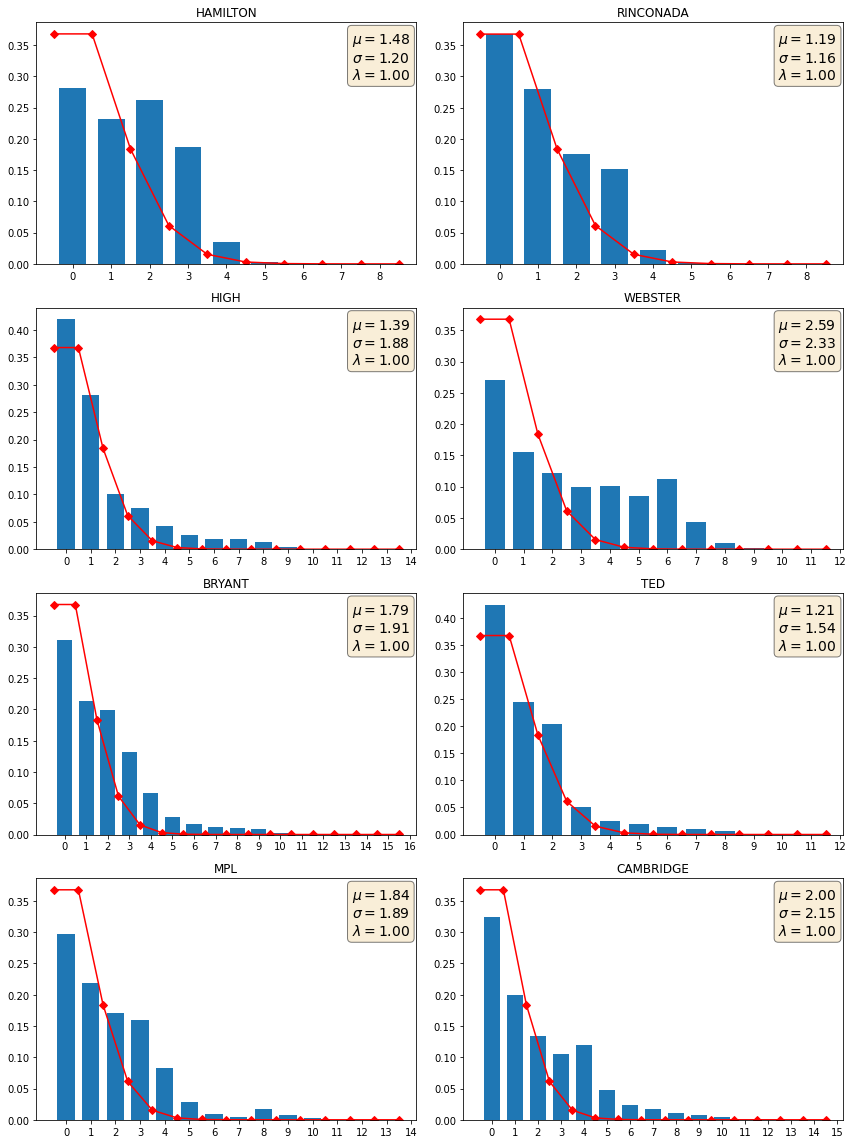

In [266]:
### Could attempt to find best fitted pdf to above distributions
plot_histograms(df_event, plot_best_estimate = True)

## Daily and weekly patterns 
#### Using quantile plots to explore patterns across clusters

In [61]:
## Add day and hour variable
df_event['Day'] = df_event['Period'].dt.dayofweek
df_event['Hour'] = df_event['Period'].dt.hour

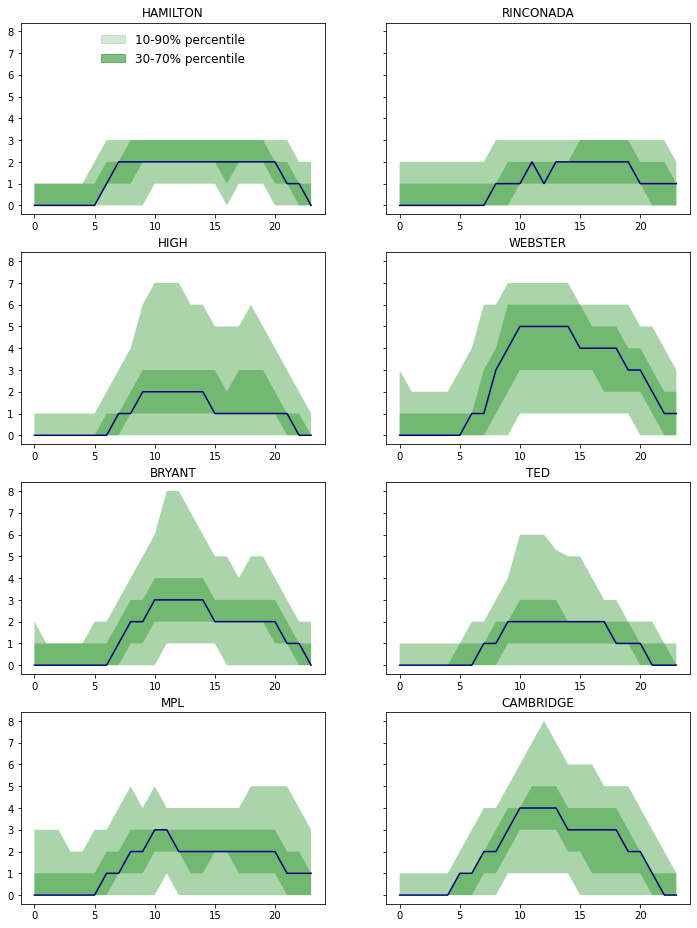

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(12, 18), sharey = True)
i = 0
j = 0
n_percentile = 3
for key in plot_list:
    tsplot_v2(df_event, n=n_percentile, time_scale = 24, Cluster = key, value = 'Sessions', percentile_min=10, percentile_max=90, plot_median=True, plot_mean=False, color='g', line_color='navy', ax1 = i, ax2 = j, plt_axes = axes)
    axes[i,j].set_title(key)
    i += 1
    if i == 4:
        j += 1
        i = 0

legend = axes[0,0].legend(loc="upper center", fontsize=12, markerscale=2, frameon=False)
handles = legend.legendHandles

# There are many more hatches available in matplotlib
for i, handle in (enumerate(handles)):
    handle.set_alpha((i+0.5)*(1/n_percentile))
    handle.set_color('green')

fig.subplots_adjust(bottom=0.2)

#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#axes[i,j].text(0.5, 0.5, textstr, transform=axes[i,j].transAxes, fontsize=14, verticalalignment='top', bbox=props)


### On consumption

In [ ]:
df_consum = df[['Start Date', 'Cluster', 'Energy (kWh)']]
df_consum['Day'] = df_consum['Start Date'].dt.dayofweek
df_consum['Hour'] = df_consum['Start Date'].dt.hour

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_4131/116872807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consum['Day'] = df_consum['Start Date'].dt.dayofweek
/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_4131/116872807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consum['Hour'] = df_consum['Start Date'].dt.hour


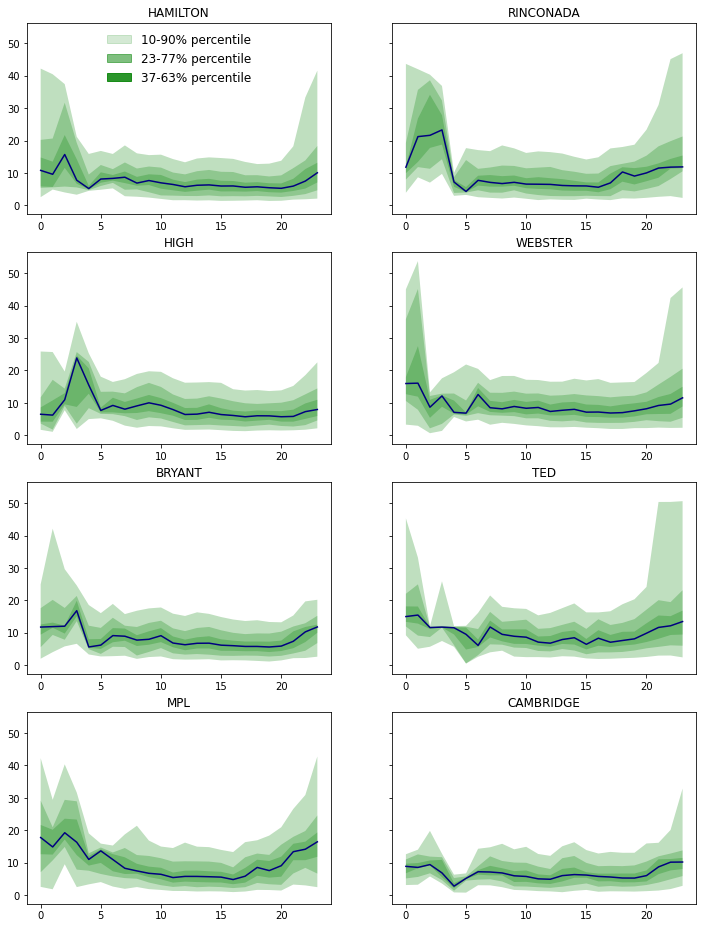

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(12, 18), sharey = True)
i = 0
j = 0

for key in plot_list:
    tsplot_v2(df_consum, n=4, time_scale = 24, Cluster = key, value = 'Energy (kWh)', percentile_min=10, percentile_max=90, plot_median=True, plot_mean=False, color='g', line_color='navy', ax1 = i, ax2 = j, plt_axes = axes)
    axes[i,j].set_title(key)
    i += 1
    if i == 4:
        j += 1
        i = 0

legend = axes[0,0].legend(loc="upper center", fontsize=12, markerscale=2, frameon=False)
handles = legend.legendHandles

# There are many more hatches available in matplotlib
for i, handle in (enumerate(handles)):
    handle.set_alpha((i+0.5)*(1/n_percentile))
    handle.set_color('green')

fig.subplots_adjust(bottom=0.2)
fig.savefig('Figures/ConsumptionPercentiles.png')

### Weekly patterns

In [ ]:
from numpy.random import default_rng
rng = default_rng()

In [ ]:
df_weekly = df_event.groupby(['Cluster','Day']).median()['Sessions']
df_weekly_jittered = df_weekly + 0.05*rng.standard_normal(df_weekly.shape)

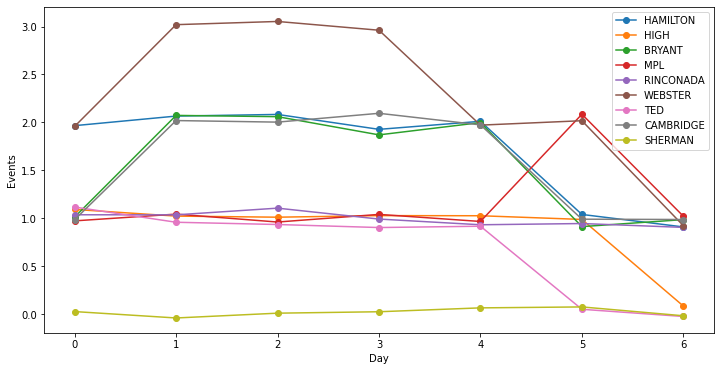

In [ ]:
fig, axes = plt.subplots(figsize=(12,6))
for key in df_event['Cluster'].unique():
    axes.plot(df_weekly_jittered[key], '-o', label = key)
    axes.set_xlabel('Day')
    axes.set_ylabel('Events')
    axes.legend()
plt.show()

## Adding max no. plugs for each cluster at any time point

In [114]:
df_event = pd.read_csv('/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_viz.csv', index_col=0, parse_dates=['Period'])
df_event['Day'] = df_event['Period'].dt.dayofweek
df_event['Hour'] = df_event['Period'].dt.hour

In [112]:
## Create start and end date from plugs table
## Uncomment below if name change is necessary
df_charging_stations_per_hub = df_charging_stations_per_hub.rename(columns = {'End Date': 'EndDate', 'Start Date': 'StartDate'})
df_charging_stations_per_hub['EndDate'] = df_charging_stations_per_hub['StartDate'].shift(-1, fill_value= df_event['Period'].iloc[-1])
#df_charging_stations_per_hub = df_charging_stations_per_hub.rename(columns = {'Hub': 'Cluster'})
#df_charging_stations_per_hub = df_charging_stations_per_hub.rename(columns = {'Hub': 'Cluster'})

In [117]:
df_charging_stations_per_hub

,Station Name,StartDate,Port Number,Cluster,No. Stations,No. Plugs per Hub,EndDate
0,PALO ALTO CA / HAMILTON #1,2011-07-29 20:17:00,2,HAMILTON,1,2.0,2011-08-02 12:26:00
1,PALO ALTO CA / HAMILTON #2,2011-08-02 12:26:00,2,HAMILTON,2,4.0,2011-09-02 20:42:00
2,PALO ALTO CA / HIGH #4,2011-09-02 20:42:00,2,HIGH,1,2.0,2011-10-10 15:23:00
3,PALO ALTO CA / BRYANT #2,2011-10-10 15:23:00,2,BRYANT,1,2.0,2011-10-13 12:49:00
4,PALO ALTO CA / BRYANT #1,2011-10-13 12:49:00,2,BRYANT,2,4.0,2014-09-24 08:26:00
5,PALO ALTO CA / MPL #4,2014-09-24 08:26:00,1,MPL,1,1.0,2014-09-24 08:36:00
6,PALO ALTO CA / MPL #6,2014-09-24 08:36:00,1,MPL,2,2.0,2014-09-24 08:42:00
7,PALO ALTO CA / MPL #2,2014-09-24 08:42:00,1,MPL,3,3.0,2014-09-27 15:54:00
8,PALO ALTO CA / MPL #1,2014-09-27 15:54:00,1,MPL,4,4.0,2014-09-28 10:45:00
9,PALO ALTO CA / MPL #5,2014-09-28 10:45:00,1,MPL,5,5.0,2014-10-05 09:50:00


In [219]:
## Merge dataframes containing events and the total number of plugs per cluster over time
#df_censored = pd.merge(df_event, df_charging_stations_per_hub, how='inner', left_on='Cluster', right_on='Cluster')
#df_censored = df_censored[(df_censored['Period']>=df_censored['StartDate']) & (df_censored['Period']<=df_censored['EndDate'])]
#df_censored = df_censored[['Period', 'Sessions', 'Cluster', 'Day', 'Hour', 'No. Plugs per Hub']]
#df_censored = df_censored.rename(columns =  {'No. Plugs per Hub': 'PlugCap'})
def assignPlugCap(df_in, df_charging_plugs):
    df_out = df_in.copy()
    

    ## Fix zero values in beginning
    df_charging_plugs.iloc[0]['StartDate'] = '2011-07-29 20:00:00'

    for i in np.arange(len(df_charging_plugs)):
        df_out.loc[(df_out['Cluster'] == df_charging_plugs['Cluster'].iloc[i]) & 
                                        (df_out['Period'] >= df_charging_plugs['StartDate'].iloc[i]) & 
                                        (df_out['Period'] <= df_charging_plugs['EndDate'].iloc[i]),
                                        'PlugCap'] = df_charging_plugs['No. Plugs per Hub'].iloc[i]

    #df_out.sort_values(['Cluster','PlugCap']).groupby('Cluster').ffill()
    df_out = df_out.fillna(method='ffill')
    return df_out

In [220]:
df_censored_v2 = assignPlugCap(df_event, df_charging_stations_per_hub)

/opt/miniconda3/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [223]:
df_censored_v2.to_csv("/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_capped.csv")

## Plot censoring scheme

In [224]:
df_censored = pd.read_csv("/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_capped.csv", index_col=0, parse_dates=['Period'])

$\eta is the percentage of time intervals where the amount sessions exceed the number of plugs (due to time aggregation)$
$\mu is the average fraction of plugs in use (out of the total number)$


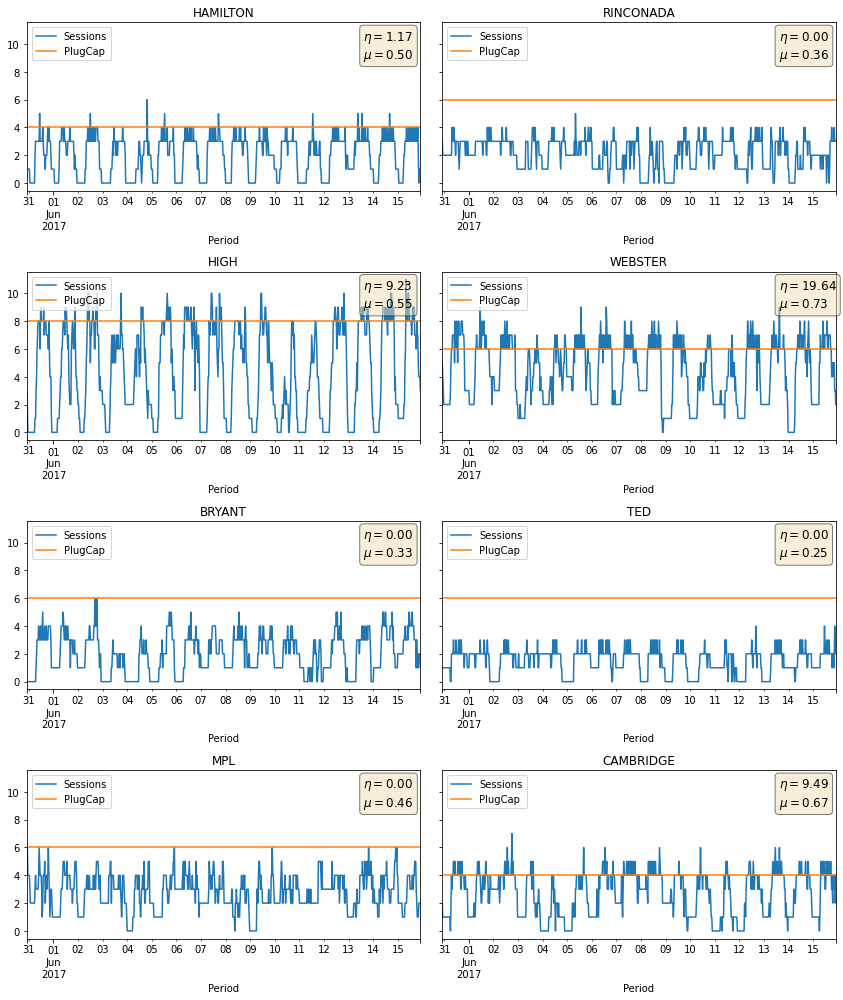

In [259]:
plot_time_series(df_censored, start_date = '2017-05-30 22:00:00', end_date = '2017-06-15 22:00:00', save_figure=True)

## Create censored dataset